# はじめの一歩

In [1]:
import torch

In [2]:
dtype = torch.float

use_gpu = False

if use_gpu:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

想定するニューラルネットワークは 100 次元の実数値 $x \in \mathbb{R}^{100}$ を入力にとり、1次元の実数予測値 $\hat{y} \in \mathbb{R}$ を返すようなものです。

$$
z = W_1^T x \\
h = {\rm relu}(z) \\
\hat{y} = W_2^T h 
$$

ここで $W_1 \in \mathbb{R}^{100 \times 1000}, W_2 \in \mathbb{R}^{10 \times 100}$ はそれぞれネットワークの重みを指します。

In [3]:
x = torch.randn(2, 3)
x.__class__

torch.Tensor

In [4]:
x.reshape(-1)

tensor([ 1.6180,  0.6957,  0.8190, -0.1657, -0.0048, -1.1411])

In [5]:
x.abs()
x

tensor([[ 1.6180,  0.6957,  0.8190],
        [-0.1657, -0.0048, -1.1411]])

In [6]:
x.abs_()
x

tensor([[ 1.6180,  0.6957,  0.8190],
        [ 0.1657,  0.0048,  1.1411]])

In [7]:
batch_size = 100
input_dim = 100
hidden_dim = 1000
outpu_dim = 10

In [8]:
variable_types = {
    "device": device,
    "dtype": dtype
}

入力データと正解ラベルをガウスノイズを用いてランダムに作成します。

In [9]:
x = torch.randn(batch_size, input_dim, **variable_types)
y = torch.randn(batch_size, outpu_dim, **variable_types)

In [10]:
# 重みの初期値はランダムに設定
w1 = torch.randn(input_dim, hidden_dim, **variable_types)
w2 = torch.randn(hidden_dim, outpu_dim, **variable_types)

In [11]:
w1.data.var(), w1.min()

(tensor(1.0107), tensor(-4.2550))

In [12]:
lr = 2e-6

## 手計算で backward

重みに対する `backward` をチェーンルールを用いて計算し、それを随時適用することで重みを更新する、というパワープレイ。

ちなみに今回のモデルに対する勾配は以下のようになる、はず。

$$
f(y, \hat{y}) = \| y - \hat{y} \|^2
$$

$$
\begin{align}
\frac{\partial f}{\partial W_2} &= - 2 (y - \hat{y}) h \\
\frac{\partial f}{\partial W_1} &= (- 2 (y - \hat{y}) W_1 {\rm diag}(H_0(h)) x )^T \\
&= -2 x^T (y - \hat{y}) W_1 {\rm diag}(H_0(h))
\end{align}
$$

ここで $H_0$ はヘヴィサイドの階段関数

In [13]:
%%time

epochs = 1000
losses = []
for i in range(epochs):
    z = x.mm(w1)

    # relu activetion
    a = z.clamp(min=0)
    pred = a.mm(w2)

    loss = ((pred - y) ** 2.).sum()
    losses.append(loss.item())

    grad_pred = 2 * (pred - y)

    grad_pred.shape

    grad_w2 = a.t().mm(grad_pred)

    grad_w2.shape

    grad_a = grad_pred.mm(w2.t())

    grad_a[z < 0] = 0

    grad_w1 = x.t().mm(grad_a)

    grad_w1.shape

    w1 -= lr * grad_w1 
    w2 -= lr * grad_w2
    
    if i % 200 == 0:
        lr *= .5

CPU times: user 11.5 s, sys: 375 ms, total: 11.9 s
Wall time: 2.97 s


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

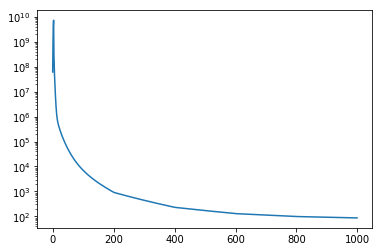

In [15]:
plt.plot(losses)
plt.yscale("log")

## Autograd を使う

先の例では自分で勾配を計算していた。
torch は自動微分が定義されているのでこれを使うとb `backword` の部分を計算グラフから自動で計算してくれる。

自動微分を用いるには `require_grad=True` にすればOK

In [16]:
variable_types["requires_grad"] = True

w1 = torch.randn(input_dim, hidden_dim, **variable_types)
w2 = torch.randn(hidden_dim, outpu_dim, **variable_types)

lr = 1e-6

losses = []
for epoch in range(epochs):
    
    # forward (順伝搬) の計算を定義するだけでOK
    pred = x.mm(w1).clamp(min=0).mm(w2)
    
    loss = (y - pred).pow(2).sum()
    
    loss.backward()
    losses.append(loss.item())

    # 以下で重みを update するがこの時の変更は autograd に追跡されたくない。
    # `with torch.no_grad()` の部分では追跡を行わないようになる。
    # 他の方法としては tensor の値を直接変更するという方法がある
    # ex). w1.data -= lr* w1.grad.data
    # しかしこの方法だと履歴を追跡できなくなる
    with torch.no_grad():
        w1 -= lr * w1.grad
        w2 -= lr * w2.grad
        
        # 破壊的に勾配の値を 0 にする
        w1.grad.zero_()
        w2.grad.zero_()

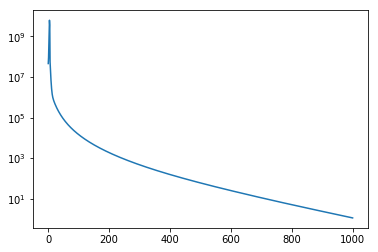

In [17]:
plt.plot(losses, "-")
plt.yscale("log")

## torch.nn を使う

In [18]:
class SimpleNNModel(torch.nn.Module):
    """
    二層のニューラルネットワークモデル"""
    
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        
        self.dense1 = torch.nn.Linear(input_dim, hidden_dim, bias=False)
        self.dense2 = torch.nn.Linear(hidden_dim, outpu_dim, bias=False)
        
    def forward(self, x):
        """
        順伝搬の計算を行って予測値を返す"""
        
        h = self.dense1(x)
        
        # equal to relu activation
        h = h.clamp(min=0)
        
        pred = self.dense2(h)
        return pred

In [19]:
model = SimpleNNModel(input_dim, outpu_dim, hidden_dim)

for c in model.children():
    print(c)

for p in model.parameters():
    print(p)
# Parameter containing:
# tensor(1.00000e-02 *
#        [[ 7.6395, -6.7308,  9.9475,  ...,  1.5201, -3.2150, -0.1836],
#         [-8.0257,  9.9207,  2.4222,  ...,  4.2445,  8.2807,  7.5381],
#         [ 3.3367,  0.5269, -0.0468,  ...,  2.7539,  9.4210,  7.7625],
#         ...,
#         [ 6.5938, -3.1973, -0.3842,  ..., -3.0842,  6.5831,  4.6253],
#         [ 0.4635, -2.5175, -9.1168,  ...,  5.4131, -5.4361, -6.6949],
#         [ 2.5444,  9.0936, -3.0305,  ...,  6.1671,  4.1751, -3.2943]])
# Parameter containing:
# tensor(1.00000e-02 *
#        [[-3.0642,  3.1571,  1.1157,  ...,  2.1682,  2.4327, -1.7542],
#         [ 0.6330, -3.1313, -1.7368,  ...,  2.4449, -2.3944,  2.3621],
#         [-0.6492,  1.6452,  0.9604,  ..., -2.4719, -0.7905,  2.3031],
#         ...,
#         [-1.0288, -3.1262, -1.0839,  ..., -0.7796, -2.2369,  2.7909],
#         [ 0.0137, -2.7335,  2.7928,  ..., -1.3900,  0.6610,  2.2154],
#         [-3.1476, -2.1980, -1.7415,  ..., -2.2474, -2.0570, -2.9524]])

Linear(in_features=100, out_features=1000, bias=False)
Linear(in_features=1000, out_features=10, bias=False)
Parameter containing:
tensor(1.00000e-02 *
       [[ 7.0615,  2.1847, -1.8890,  ..., -5.0784, -4.6400, -3.7641],
        [ 9.6789,  9.0186,  9.6077,  ..., -5.5705,  8.3330, -5.8871],
        [ 2.7536, -4.8678,  0.5568,  ..., -8.3201,  4.0804,  4.0012],
        ...,
        [-7.0127, -9.4717, -4.1426,  ...,  2.2844, -8.0036, -4.9633],
        [ 7.8512, -2.9269,  5.6234,  ...,  9.6199,  1.7483, -4.1527],
        [ 9.6325, -1.6357,  7.5426,  ...,  4.2192,  7.4679,  3.9888]])
Parameter containing:
tensor(1.00000e-02 *
       [[-1.0663, -2.7280,  3.1288,  ...,  0.8447, -1.5913, -1.7122],
        [-0.4052,  2.2802,  0.8896,  ...,  1.0402, -0.1711, -0.9671],
        [ 3.0209, -1.2366, -2.0471,  ..., -2.6909,  2.9175,  0.4838],
        ...,
        [-1.5708, -2.1162,  1.6232,  ...,  3.0399, -2.5340,  1.8406],
        [ 2.1781,  0.2861, -0.5789,  ...,  1.7480, -0.0139,  2.7987],
        

In [20]:
model = model.to(device)

In [21]:
# `criterion`: 予測値と正解ラベルとの差分を計算するオブジェクト
# `size_averaging` を `False` にすると, 与えられたバッチ n それぞれの rmse を合計した loss を返す。
# デフォルトでは `True` (すなわちバッチそれぞれの値を配列として返す)
criterion = torch.nn.MSELoss(size_average=False)

# 勾配の初期化, 重みの update などの方法(アルゴリズム) が torch.optima にいろいろ定義されている
# 第一引数にこの optimizer で update したいパラメータの配列を渡す. 
# 今回は単純な stochastic gradient descent を使う
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=.8, weight_decay=1e-8, nesterov=True)

In [22]:
losses_sgd = []
for epoch in range(epochs):
    pred = model.forward(x)
    loss = criterion(pred, y)
    losses_sgd.append(loss.item())
    # 登録されたパラメータの勾配を 0 にする
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

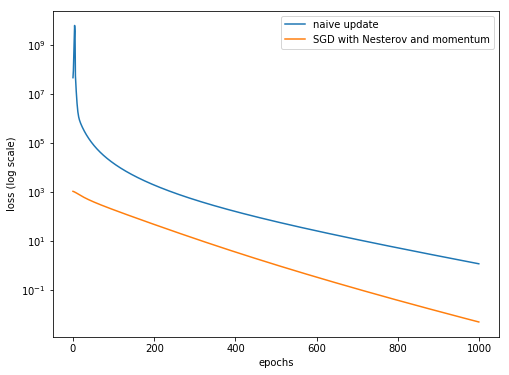

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(losses, label="naive update")
plt.plot(losses_sgd, label="SGD with Nesterov and momentum")
plt.legend(loc=1)
plt.xlabel("epochs")
plt.ylabel("loss (log scale)")
plt.yscale("log")
plt.savefig("loss_transition.png", dpi=150)